In [1]:
%pip install -q scikit-learn

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import numpy as np
import pandas as pd
import random
import shutil

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


Note: you may need to restart the kernel to use updated packages.


c:\Users\Lenovo\anaconda3\envs\PlantDisease\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
def create_temp_dataset(original_dir, temp_dir, max_per_class=1000, seed=42):
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    random.seed(seed)
    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected = random.sample(images, min(len(images), max_per_class))
            target_class_dir = os.path.join(temp_dir, class_name)
            os.makedirs(target_class_dir)
            for img in selected:
                src = os.path.join(class_path, img)
                dst = os.path.join(target_class_dir, img)
                shutil.copyfile(src, dst)

def load_dataset_from_temp(temp_dir, img_size=(224, 224), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        temp_dir,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        label_mode='categorical'
    )
    return dataset


In [ ]:
# Paths
original_train_path = "train"
original_val_path = "val"
temp_train_path = "Dataset/Reduced_Train"
temp_val_path = "Dataset/Reduced_Val"

# Reduce
create_temp_dataset(original_train_path, temp_train_path, max_per_class=3000)
create_temp_dataset(original_val_path, temp_val_path, max_per_class=600)

# Load reduced datasets
train_ds = load_dataset_from_temp(temp_train_path)
val_ds = load_dataset_from_temp(temp_val_path)

# Load test dataset (full)
test_ds = image_dataset_from_directory('test', image_size=(224, 224), batch_size=64, label_mode='categorical', shuffle=False)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 12000 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 968 files belonging to 4 classes.


In [4]:
def build_model(base_model_name, input_shape=(224, 224, 3), num_classes=4):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.MobileNetV3Large(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet',
            include_preprocessing=True
        )
    elif base_model_name == 'resnet':
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'efficientnet':
        base_model = tf.keras.applications.EfficientNetB0(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError("Unsupported model name")

    base_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [5]:
def train_model(model, train_data, val_data, epochs, model_name):
    print(f"\n🚀 Training {model_name}...")
    start = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    end = time.time()

    model.save(f'{model_name}_model.keras')
    with open(f'{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ {model_name} training completed in {(end - start):.2f} seconds.")
    return history, end - start


In [6]:
mobilenet_model = build_model('mobilenet')
mobilenet_history, mobilenet_time = train_model(mobilenet_model, train_ds, val_ds, epochs=10, model_name='mobilenetv3')

resnet_model = build_model('resnet')
resnet_history, resnet_time = train_model(resnet_model, train_ds, val_ds, epochs=10, model_name='resnet50')

efficientnet_model = build_model('efficientnet')
efficientnet_history, efficientnet_time = train_model(efficientnet_model, train_ds, val_ds, epochs=10, model_name='efficientnetb0')


🚀 Training mobilenetv3...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 276ms/step - accuracy: 0.4622 - loss: 1.3226 - val_accuracy: 0.9062 - val_loss: 0.3465
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7056 - loss: 0.7437 - val_accuracy: 0.9688 - val_loss: 0.2640
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.7615 - loss: 0.6239 - val_accuracy: 0.9688 - val_loss: 0.2211
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7744 - loss: 0.5805 - val_accuracy: 0.9688 - val_loss: 0.1978
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.7961 - loss: 0.5343 - val_accuracy: 0.9688 - val_loss: 0.1797
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.8107 - loss: 0.5034 - val_accuracy: 0.9688 - val_loss: 0.1618
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8183 - loss: 0.4813 - val_accuracy: 0.9688 - val_loss: 0.1581
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step 

In [7]:
def evaluate_model_on_test(model, test_ds, model_name="Model"):
    print(f"🔍 Evaluating {model_name} on test set...")

    true_labels = tf.concat([y for x, y in test_ds], axis=0)
    Y_true = tf.argmax(true_labels, axis=1)

    pred_probs = model.predict(test_ds)
    Y_pred = tf.argmax(pred_probs, axis=1)

    acc = accuracy_score(Y_true, Y_pred)
    prec = precision_score(Y_true, Y_pred, average='macro')
    rec = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')

    print("📄 Classification Report:")
    print(classification_report(Y_true, Y_pred))

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }


🔍 Evaluating MobileNetV3 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       242
           1       0.97      0.98      0.97       242
           2       0.95      0.96      0.95       242
           3       0.99      0.97      0.98       242

    accuracy                           0.96       968
   macro avg       0.97      0.96      0.96       968
weighted avg       0.97      0.96      0.96       968



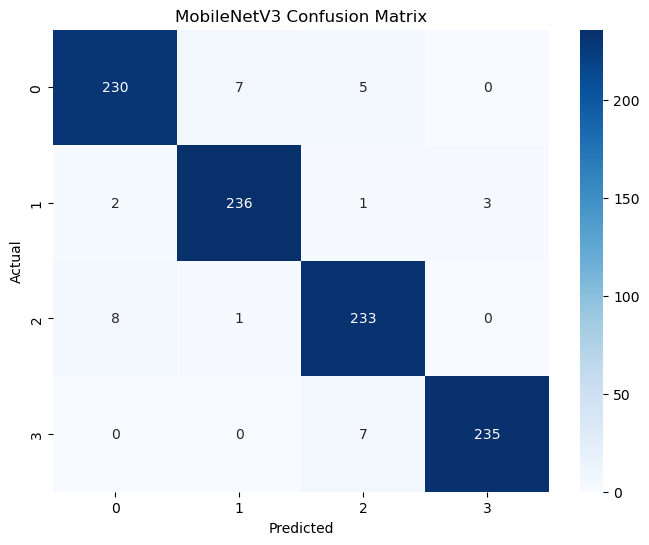

🔍 Evaluating ResNet50 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       242
           1       0.95      0.95      0.95       242
           2       0.94      0.95      0.94       242
           3       0.98      0.97      0.98       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



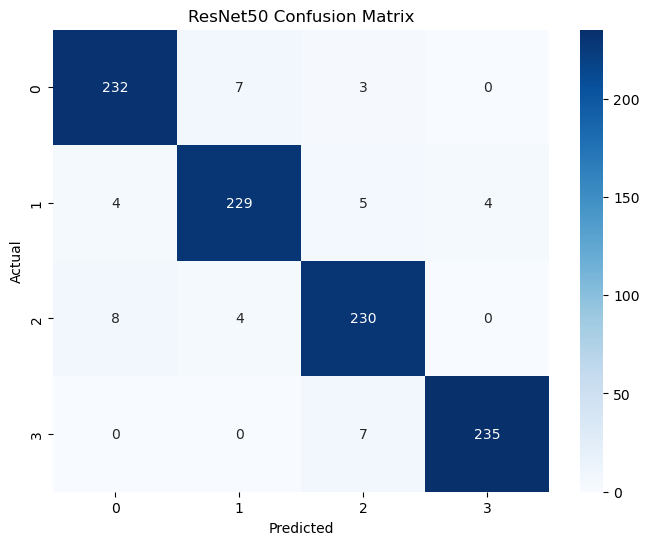

🔍 Evaluating EfficientNetB0 on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 650ms/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       242
           1       0.97      0.97      0.97       242
           2       0.97      0.98      0.97       242
           3       1.00      0.98      0.99       242

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



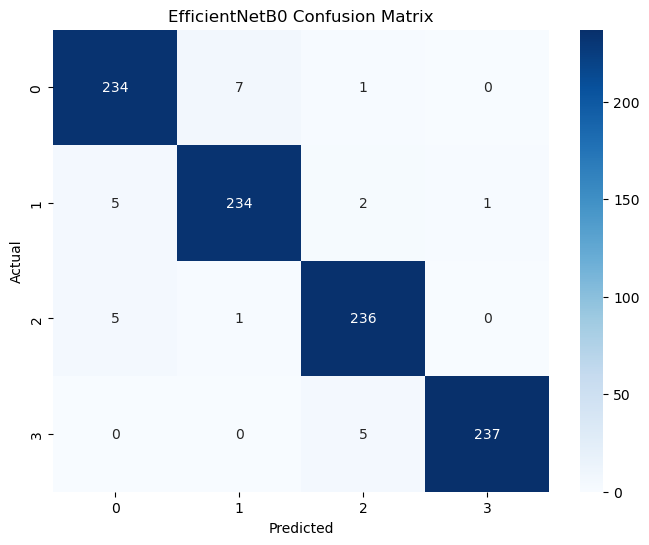

In [8]:
mobilenet_results = evaluate_model_on_test(mobilenet_model, test_ds, "MobileNetV3")
resnet_results = evaluate_model_on_test(resnet_model, test_ds, "ResNet50")
efficientnet_results = evaluate_model_on_test(efficientnet_model, test_ds, "EfficientNetB0")

In [9]:
mobilenet_size = os.path.getsize('mobilenetv3_model.keras') / (1024 * 1024)
resnet_size = os.path.getsize('resnet50_model.keras') / (1024 * 1024)
efficientnet_size = os.path.getsize('efficientnetb0_model.keras') / (1024 * 1024)

comparison_df = pd.DataFrame([
    {**mobilenet_results, 'Model Size (MB)': mobilenet_size, 'Training Time (s)': mobilenet_time},
    {**resnet_results, 'Model Size (MB)': resnet_size, 'Training Time (s)': resnet_time},
    {**efficientnet_results, 'Model Size (MB)': efficientnet_size, 'Training Time (s)': efficientnet_time}
])

comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,Model Size (MB),Training Time (s)
0,MobileNetV3,0.964876,0.965024,0.964876,0.964909,13.502170,770.225276
1,ResNet50,0.956612,0.956756,0.956612,0.956657,93.617665,4037.167377
2,EfficientNetB0,0.972107,0.972242,0.972107,0.972150,18.139707,1246.811628


In [10]:
def plot_training_curves(history, model_name):
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


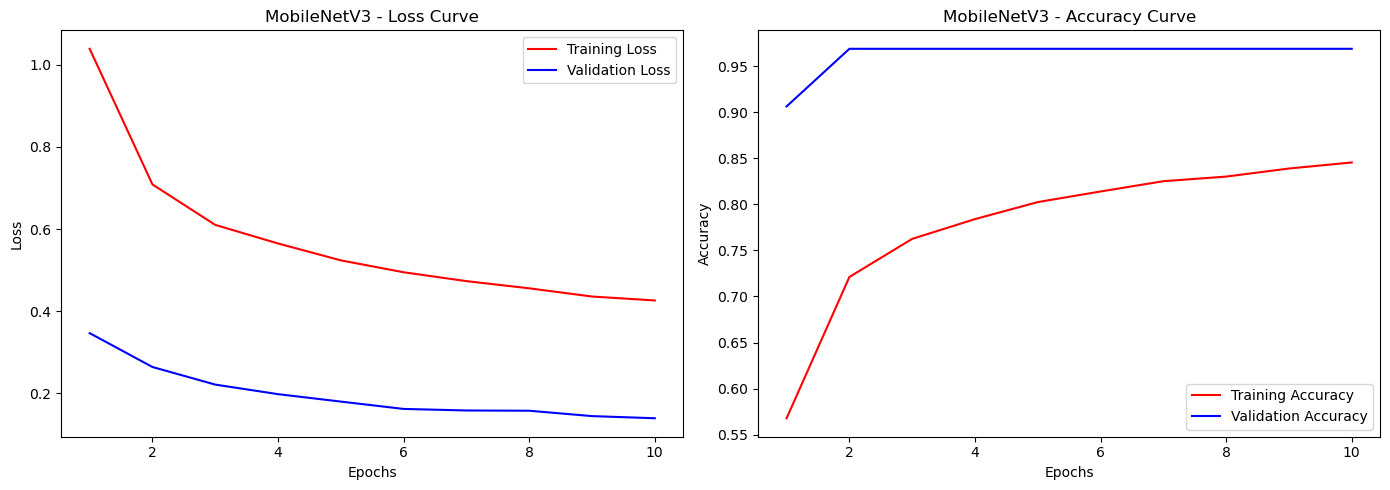

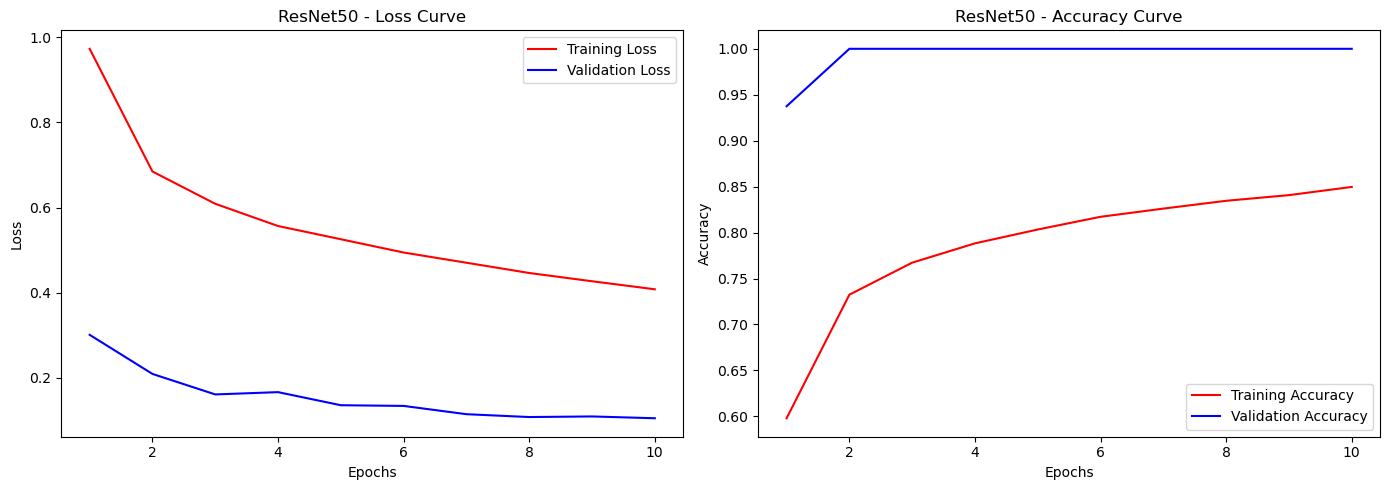

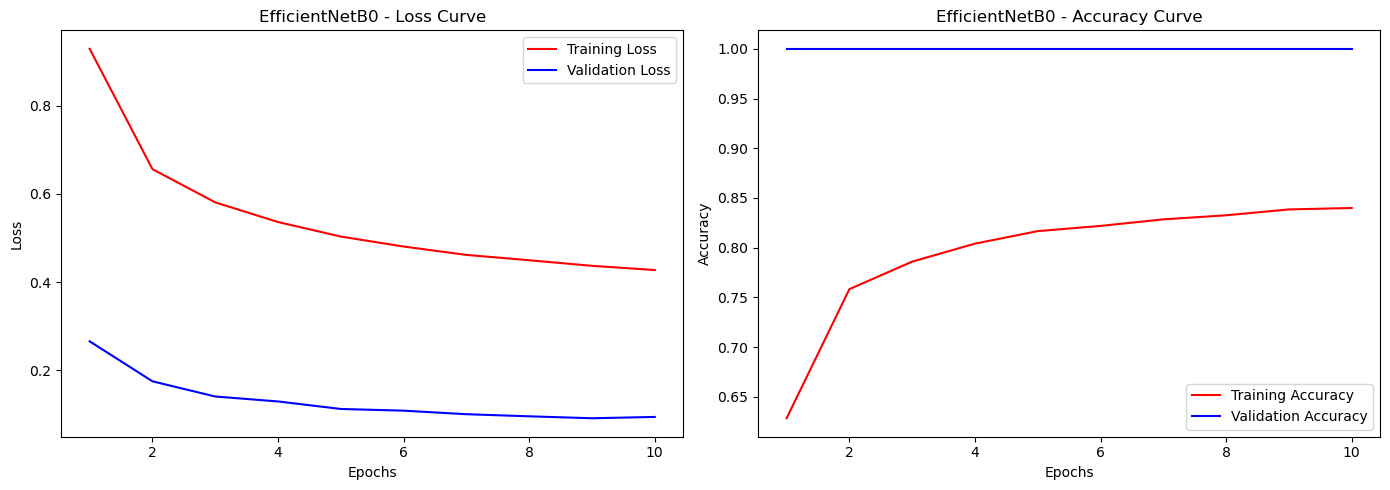

In [11]:
with open('mobilenetv3_history.pkl', 'rb') as f:
    mob_history = pickle.load(f)
plot_training_curves(mob_history, 'MobileNetV3')

with open('resnet50_history.pkl', 'rb') as f:
    resnet_history = pickle.load(f)
plot_training_curves(resnet_history, 'ResNet50')

with open('efficientnetb0_history.pkl', 'rb') as f:
    eff_history = pickle.load(f)
plot_training_curves(eff_history, 'EfficientNetB0')


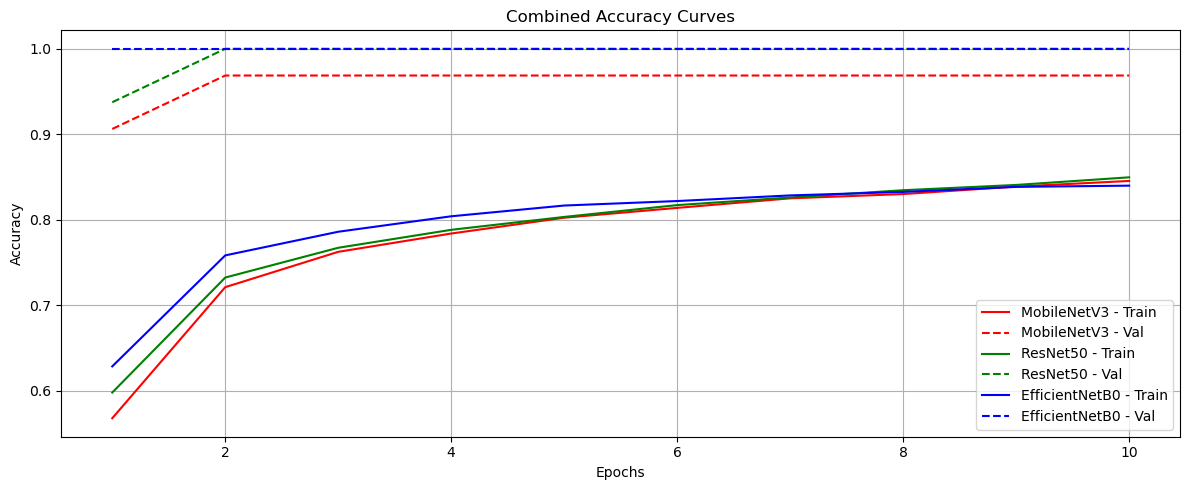

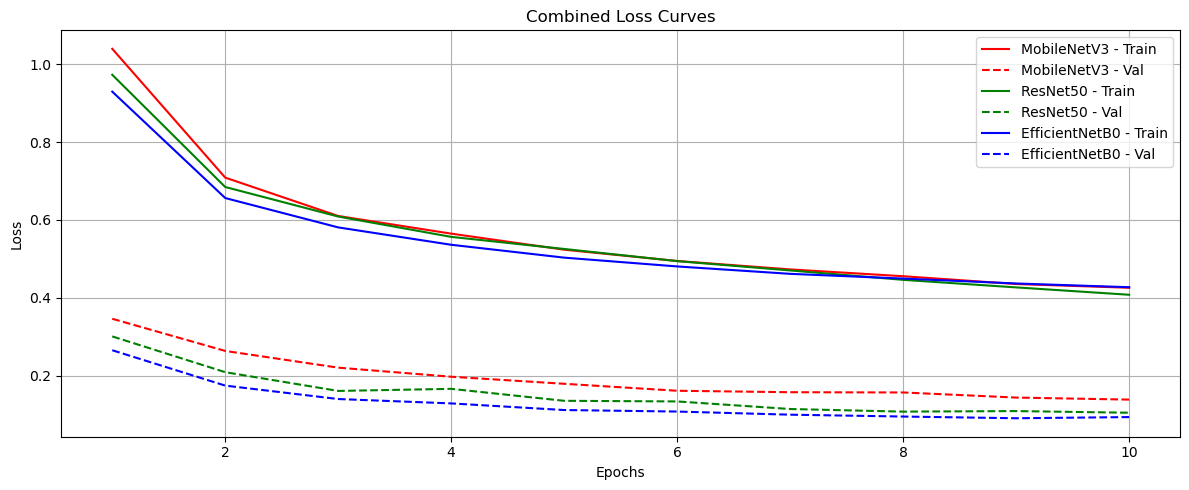

In [12]:
def plot_combined_metrics():
    models = {
        'MobileNetV3': 'mobilenetv3_history.pkl',
        'ResNet50': 'resnet50_history.pkl',
        'EfficientNetB0': 'efficientnetb0_history.pkl'
    }

    colors = {'MobileNetV3': 'r', 'ResNet50': 'g', 'EfficientNetB0': 'b'}
    styles = {'train': '-', 'val': '--'}

    plt.figure(figsize=(12, 5))
    for name, file in models.items():
        with open(file, 'rb') as f:
            hist = pickle.load(f)
        epochs = range(1, len(hist['accuracy']) + 1)
        plt.plot(epochs, hist['accuracy'], color=colors[name], linestyle=styles['train'], label=f'{name} - Train')
        plt.plot(epochs, hist['val_accuracy'], color=colors[name], linestyle=styles['val'], label=f'{name} - Val')
    plt.title('Combined Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    for name, file in models.items():
        with open(file, 'rb') as f:
            hist = pickle.load(f)
        epochs = range(1, len(hist['loss']) + 1)
        plt.plot(epochs, hist['loss'], color=colors[name], linestyle=styles['train'], label=f'{name} - Train')
        plt.plot(epochs, hist['val_loss'], color=colors[name], linestyle=styles['val'], label=f'{name} - Val')
    plt.title('Combined Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_metrics()


In [3]:
import tensorflow as tf
import numpy as np

# Modify this for your model path
model_paths = {
    "mobilenetv3_model.keras": "mobilenetv3_model_fixed.keras",
    "resnet50_model.keras": "resnet50_model_fixed.keras",
    "efficientnetb0_model.keras": "efficientnetb0_model_fixed.keras"
}

for original_path, fixed_path in model_paths.items():
    model = tf.keras.models.load_model(original_path)
    
    # Run a dummy prediction to "build" the model
    dummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)
    _ = model.predict(dummy_input)

    # Save to a new file
    model.save(fixed_path)
    print(f"✅ Fixed and saved: {fixed_path}")


c:\Users\Lenovo\anaconda3\envs\PlantDisease\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Fixed and saved: mobilenetv3_model_fixed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Fixed and saved: resnet50_model_fixed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Fixed and saved: efficientnetb0_model_fixed.keras


In [4]:
mobilenet_model = tf.keras.models.load_model("mobilenetv3_model_fixed.keras")
resnet_model = tf.keras.models.load_model("resnet50_model_fixed.keras")
efficient_model = tf.keras.models.load_model("efficientnetb0_model_fixed.keras")
